In [ ]:
!pip install -q transformers datasets evaluate accelerate sentencepiece seaborn wordcloud

In [ ]:
!pip install --upgrade transformers accelerate datasets evaluate --quiet

In [ ]:
import os
import time
import json
import math
import shutil
from pathlib import Path
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    EvalPrediction
)
import evaluate

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc,
    precision_recall_curve,
    average_precision_score,
)
from sklearn.preprocessing import label_binarize
from wordcloud import WordCloud

%matplotlib inline
sns.set(style="whitegrid")

In [ ]:
MODEL_NAME = "Shushant/nepaliBERT"
DATASET_NAME = "Shushant/NepaliSentiment"
OUTPUT_DIR = "./nepali_sentiment_run"
MAX_LEN = 128
BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 2e-5
SEED = 42

os.makedirs(OUTPUT_DIR, exist_ok=True)


In [ ]:
dataset = load_dataset(DATASET_NAME)
print(dataset)

print("Train columns:", dataset["train"].column_names)
print("Sample:", dataset["train"][0])
# show label distribution
def show_label_dist(ds, split_name):
    labels = ds[split_name]["label"]
    cnt = Counter(labels)
    print(f"{split_name} label counts:", dict(cnt))
show_label_dist(dataset, "train")

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1996
    })
})
Train columns: ['text', 'label']
Sample: {'text': 'बजार ले जसरी ट्रेन्ड चेन्ज गर्यो यो हेर्दा तत्काल प्रोफिट बूकिङ आउने सम्भावना रहेन ! भोलि अर्को ट्रेन्ड समात्न सक्ने अबस्था पनि दरो छ', 'label': '2'}
train label counts: {'2': 1236, '1': 2378, '0': 2377, '20': 1, '11': 1, '-': 5, 'o': 1, '--': 1}


In [ ]:
def valid_text(example):
    t = example["text"]

    # Case 1: None value
    if t is None:
        return False

    # Case 2: Non-string values
    if not isinstance(t, str):
        return False

    t_clean = t.strip().lower()

    # Case 3: Empty or garbage values
    if t_clean == "":
        return False

    if t_clean in ["none", "-", "null", "n/a", "na"]:
        return False

    return True

dataset = dataset.filter(valid_text)

Filter:   0%|          | 0/5999 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1995 [00:00<?, ? examples/s]

In [ ]:
def clean_invalid(example):
    return example["label"] in ["0", "1", "2"]  

dataset = dataset.filter(clean_invalid)

def fix_label_format(ex):
    ex["label"] = int(ex["label"])
    return ex

dataset = dataset.map(fix_label_format)

Filter:   0%|          | 0/5999 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1995 [00:00<?, ? examples/s]

Map:   0%|          | 0/5990 [00:00<?, ? examples/s]

Map:   0%|          | 0/1993 [00:00<?, ? examples/s]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# determine number of labels from dataset
unique_labels = sorted(set(dataset["train"]["label"]))
NUM_LABELS = len(unique_labels)
print("Detected labels:", unique_labels, "num_labels=", NUM_LABELS)

model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)

Detected labels: [0, 1, 2] num_labels= 3


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Shushant/nepaliBERT and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def preprocess_fn(batch):
    # Convert every text to string
    texts = [str(t) if t is not None else "" for t in batch["text"]]

    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN,
    )

tokenized = dataset.map(preprocess_fn, batched=True)
tokenized = tokenized.rename_column("label", "labels")
tokenized.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
print(tokenized)

Map:   0%|          | 0/5990 [00:00<?, ? examples/s]

Map:   0%|          | 0/1993 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5990
    })
    test: Dataset({
        features: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1993
    })
})


In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred: EvalPrediction):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_metric.compute(predictions=preds, references=labels)["accuracy"]
    f1w = f1_metric.compute(predictions=preds, references=labels, average="weighted")["f1"]
    return {"accuracy": acc, "f1": f1w}

In [ ]:
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=100,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=2,
    fp16=True,
    num_train_epochs=EPOCHS,
    weight_decay=0.01,
    learning_rate=LEARNING_RATE,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    save_total_limit=2,
    seed=SEED,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["test"] if "test" in tokenized else tokenized["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

/tmp/ipython-input-2134680397.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
train_result = trainer.train()
trainer.save_model(os.path.join(OUTPUT_DIR, "final_model"))
tokenizer.save_pretrained(os.path.join(OUTPUT_DIR, "final_model"))
# Save train state & metrics
metrics = train_result.metrics
with open(os.path.join(OUTPUT_DIR, "train_metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)
print("Training finished. Metrics:", metrics)

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.800310,0.649272,0.640193
2,0.776700,0.781286,0.661315,0.656854
3,0.582200,0.783217,0.660311,0.657652


Training finished. Metrics: {'train_runtime': 263.4504, 'train_samples_per_second': 68.21, 'train_steps_per_second': 1.07, 'total_flos': 1182037029143040.0, 'train_loss': 0.6301429694425975, 'epoch': 3.0}


In [ ]:
# Run prediction on test set 
pred = trainer.predict(tokenized["test"])
y_true = pred.label_ids
y_logits = pred.predictions
y_pred = np.argmax(y_logits, axis=-1)

# Save raw predictions
np.save(os.path.join(OUTPUT_DIR, "y_true.npy"), y_true)
np.save(os.path.join(OUTPUT_DIR, "y_logits.npy"), y_logits)
np.save(os.path.join(OUTPUT_DIR, "y_pred.npy"), y_pred)

# Print classification report
target_names = [str(l) for l in unique_labels]  
report = classification_report(y_true, y_pred, digits=4)
print("Classification report:\n", report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

Classification report:
               precision    recall  f1-score   support

           0     0.5809    0.7192    0.6427       609
           1     0.7986    0.7545    0.7759       888
           2     0.5200    0.4194    0.4643       496

    accuracy                         0.6603      1993
   macro avg     0.6332    0.6310    0.6276      1993
weighted avg     0.6627    0.6603    0.6577      1993

Confusion matrix:
 [[438  69 102]
 [128 670  90]
 [188 100 208]]


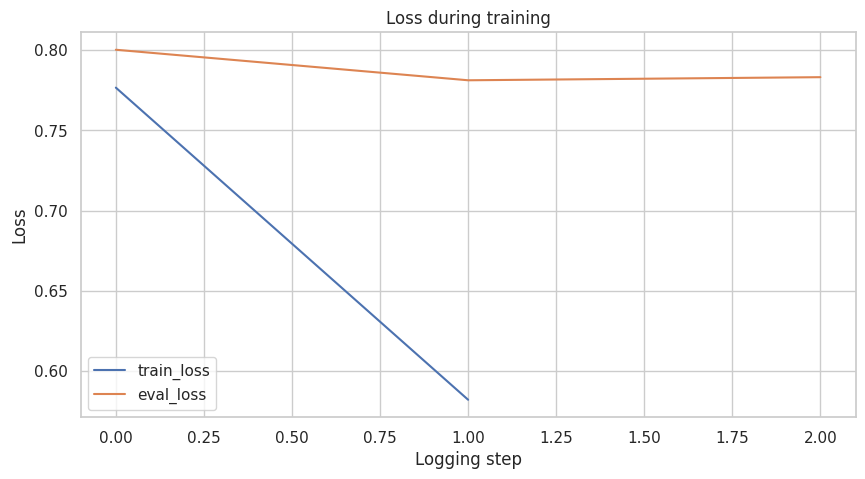

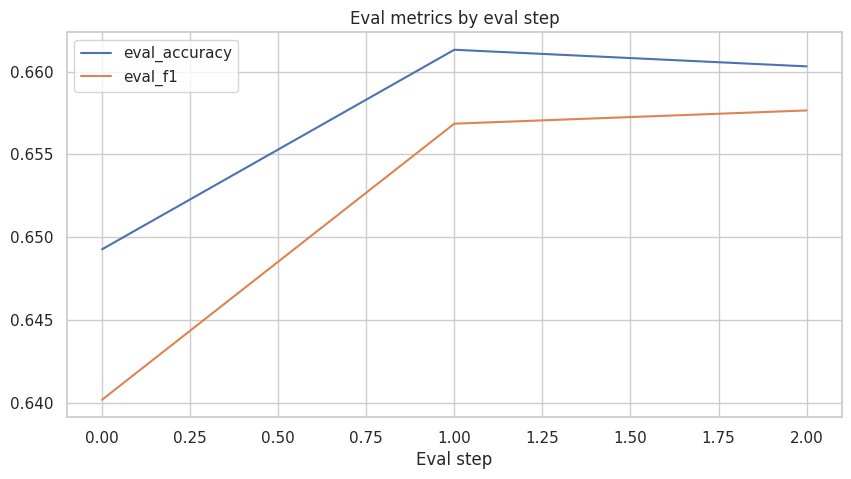

In [ ]:
logs = trainer.state.log_history
df_logs = pd.DataFrame(logs)

plt.figure(figsize=(10, 5))
if "loss" in df_logs:
    plt.plot(df_logs["loss"].dropna().reset_index(drop=True), label="train_loss")
if "eval_loss" in df_logs:
    plt.plot(df_logs["eval_loss"].dropna().reset_index(drop=True), label="eval_loss")
plt.title("Loss during training")
plt.xlabel("Logging step")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
if "eval_accuracy" in df_logs:
    plt.plot(df_logs["eval_accuracy"].dropna().reset_index(drop=True), label="eval_accuracy")
if "eval_f1" in df_logs:
    plt.plot(df_logs["eval_f1"].dropna().reset_index(drop=True), label="eval_f1")
plt.title("Eval metrics by eval step")
plt.xlabel("Eval step")
plt.legend()
plt.show()

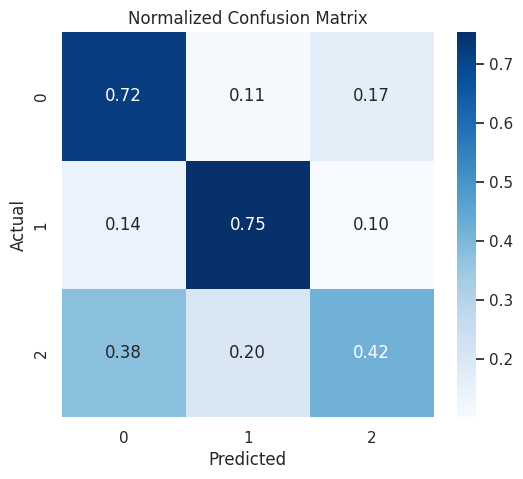

In [ ]:
cm_norm = cm.astype("float") / (cm.sum(axis=1)[:, np.newaxis] + 1e-9)
plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=target_names, yticklabels=target_names)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Normalized Confusion Matrix")
plt.show()

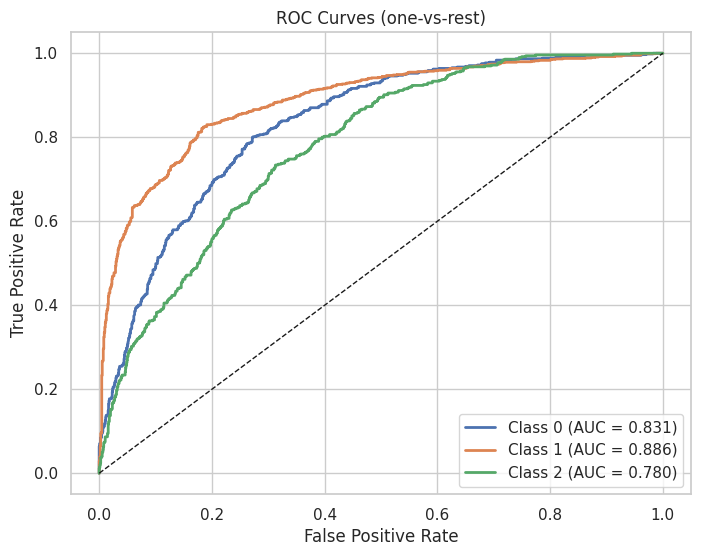

In [ ]:
# Binarize labels for multiclass roc
y_score = None
if y_logits.shape[1] == NUM_LABELS:
    # softmax probabilities
    import scipy.special
    y_score = scipy.special.softmax(y_logits, axis=1)
else:
    y_score = y_logits

y_true_bin = label_binarize(y_true, classes=unique_labels)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_LABELS):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot
plt.figure(figsize=(8,6))
for i in range(NUM_LABELS):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"Class {unique_labels[i]} (AUC = {roc_auc[i]:.3f})")
plt.plot([0,1],[0,1],"k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (one-vs-rest)")
plt.legend(loc="lower right")
plt.show()

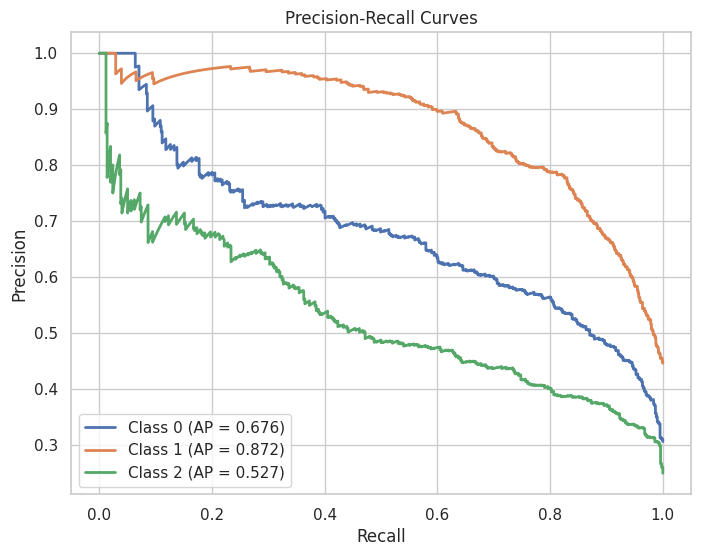

In [ ]:
precision = dict()
recall = dict()
avg_precision = dict()
for i in range(NUM_LABELS):
    precision[i], recall[i], _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
    avg_precision[i] = average_precision_score(y_true_bin[:, i], y_score[:, i])

plt.figure(figsize=(8,6))
for i in range(NUM_LABELS):
    plt.plot(recall[i], precision[i], lw=2, label=f"Class {unique_labels[i]} (AP = {avg_precision[i]:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend(loc="lower left")
plt.show()

In [ ]:
bad = [t for t in dataset["train"]["text"] if not isinstance(t, str)]
bad[:10]

[]

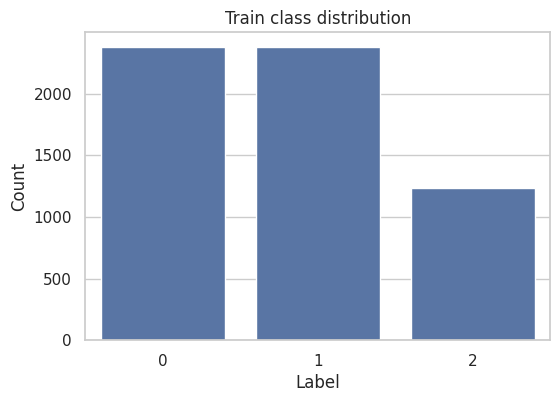

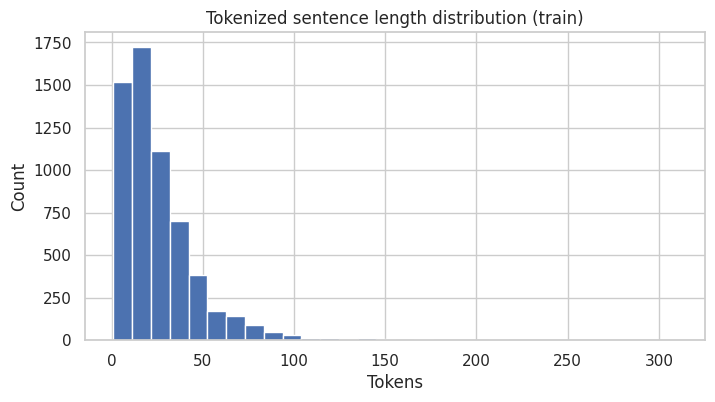

In [ ]:
# Class distribution
train_labels = np.array(dataset["train"]["label"])
plt.figure(figsize=(6,4))
sns.countplot(x=train_labels)
plt.title("Train class distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

# Sentence length distribution
lengths = [len(tokenizer.tokenize(t)) for t in dataset["train"]["text"]]
plt.figure(figsize=(8,4))
plt.hist(lengths, bins=30)
plt.title("Tokenized sentence length distribution (train)")
plt.xlabel("Tokens")
plt.ylabel("Count")
plt.show()

In [ ]:
# Create a small DataFrame of examples, predictions, logits
test_texts = dataset["test"]["text"]
df = pd.DataFrame({
    "text": test_texts,
    "true": y_true,
    "pred": y_pred,
})
# incorrectly predicted
errors = df[df["true"] != df["pred"]]
print("Total errors:", len(errors))
errors.head(20)
# Save to CSV for manual review
errors.to_csv(os.path.join(OUTPUT_DIR, "misclassified_samples.csv"), index=False)

Total errors: 677


In [ ]:
report_dict = classification_report(y_true, y_pred, output_dict=True)
summary = {
    "classification_report": report_dict,
    "confusion_matrix": cm.tolist(),
    "roc_auc": {str(k): float(v) for k,v in roc_auc.items()},
    "avg_precision": {str(k): float(v) for k,v in avg_precision.items()}
}
with open(os.path.join(OUTPUT_DIR, "evaluation_summary.json"), "w") as f:
    json.dump(summary, f, indent=2, ensure_ascii=False)
print("Saved evaluation_summary.json")

Saved evaluation_summary.json


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_path = "/content/nepali_sentiment_run/checkpoint-282"   

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [ ]:
import torch

text = "तपाईं कहाँ जाँदै हुनुहुन्छ।"

inputs = tokenizer(text, return_tensors="pt", truncation=True)

with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits
pred = torch.argmax(logits, dim=1).item()

print("Predicted label:", pred)

Predicted label: 2


In [ ]:
!zip -r model.zip /content/nepali_sentiment_run

  adding: content/nepali_sentiment_run/ (stored 0%)
  adding: content/nepali_sentiment_run/evaluation_summary.json (deflated 63%)
  adding: content/nepali_sentiment_run/checkpoint-282/ (stored 0%)
  adding: content/nepali_sentiment_run/checkpoint-282/model.safetensors (deflated 7%)
  adding: content/nepali_sentiment_run/checkpoint-282/training_args.bin (deflated 53%)
  adding: content/nepali_sentiment_run/checkpoint-282/tokenizer_config.json (deflated 74%)
  adding: content/nepali_sentiment_run/checkpoint-282/rng_state.pth (deflated 26%)
  adding: content/nepali_sentiment_run/checkpoint-282/scaler.pt (deflated 64%)
  adding: content/nepali_sentiment_run/checkpoint-282/optimizer.pt (deflated 26%)
  adding: content/nepali_sentiment_run/checkpoint-282/trainer_state.json (deflated 64%)
  adding: content/nepali_sentiment_run/checkpoint-282/special_tokens_map.json (deflated 42%)
  adding: content/nepali_sentiment_run/checkpoint-282/tokenizer.json (deflated 76%)
  adding: content/nepali_senti

In [ ]:
!unzip checkpoint-750.zip -d model/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir -p "/content/drive/My Drive/models"
!cp /content/model.zip "/content/drive/My Drive/models/"

cp: cannot create regular file '/content/drive/My Drive/models/': Not a directory


In [2]:
!pip install onnx onnxruntime optimum[onnxruntime] --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 80.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.3/192.3 kB 17.7 MB/s eta 0:00:00


In [6]:
!zip -r model_onnx.zip /content/model/final_model_onnx

  adding: content/model/final_model_onnx/ (stored 0%)
  adding: content/model/final_model_onnx/config.json (deflated 52%)
  adding: content/model/final_model_onnx/vocab.txt (deflated 72%)
  adding: content/model/final_model_onnx/tokenizer_config.json (deflated 73%)
  adding: content/model/final_model_onnx/model.onnx (deflated 7%)
  adding: content/model/final_model_onnx/tokenizer.json (deflated 76%)
  adding: content/model/final_model_onnx/special_tokens_map.json (deflated 80%)


In [3]:
!unzip final_model.zip -d model/

Archive:  final_model.zip
   creating: model/final_model/
  inflating: model/final_model/config.json  
  inflating: model/final_model/model.safetensors  
  inflating: model/final_model/special_tokens_map.json  
  inflating: model/final_model/tokenizer.json  
  inflating: model/final_model/tokenizer_config.json  
  inflating: model/final_model/training_args.bin  
  inflating: model/final_model/vocab.txt  


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from optimum.onnxruntime import ORTModelForSequenceClassification
import onnx

MODEL_PATH = "model/final_model"   
ONNX_PATH = "model/final_model_onnx"

print("Loading PyTorch model...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

# Export to ONNX
print("Exporting to ONNX...")
model = ORTModelForSequenceClassification.from_pretrained(
    MODEL_PATH,
    export=True,                       
    file_name="model.onnx"
)

model.save_pretrained(ONNX_PATH)
tokenizer.save_pretrained(ONNX_PATH)

print("Export complete!")

Multiple distributions found for package optimum. Picked distribution: optimum-onnx
`file_name` was set to `model.onnx` but will be ignored as the model will be converted to ONNX


Loading PyTorch model...
Exporting to ONNX...


/usr/local/lib/python3.12/dist-packages/transformers/modeling_attn_mask_utils.py:196: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  inverted_mask = torch.tensor(1.0, dtype=dtype) - expanded_mask


Export complete!
